In [1]:
# Data visualization
import matplotlib.pyplot as plt 

# Data manipulation
import pandas as pd
import numpy as np
import csv
from zipfile import ZipFile

In [2]:
# Webscraping
import glob
import requests
from bs4 import BeautifulSoup
import time
import datetime
from pandas.core.common import flatten
import os
from itertools import chain
from tqdm import tqdm
import json
import urllib.request

In [3]:
# Parsing and pre-processing
from glob import glob
import os 
import re

from pdfminer.high_level import extract_text
import pdfplumber
from langdetect import detect, DetectorFactory

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from string import punctuation
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [4]:
# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim

In [5]:
# Logistic and XGboost
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score
from xgboost import XGBClassifier
import pickle

In [6]:
# LSTM 
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
import gc

c:\Users\admin\anaconda3\envs\thesis\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# BERT models
from torch.utils.data import TensorDataset, RandomSampler, SequentialSampler
import transformers
from transformers import AutoModel, BertTokenizerFast

In [8]:
# specify GPU
device = "cuda" if torch.cuda.is_available() else "cpu"

In [403]:
df = pd.read_json(r"../../../data/processed/data_merged_2023_03_08.json")

### I. Clean Simplified Text and Create sec_text

In [404]:
import re

def _parse_simplified_text2(text):
    # Define the start and end patterns
    start_pattern = re.compile(r'(?i)business activities of the undertakings concerned are|business activities')
    end_pattern = re.compile(r'(?i)after examination of the notification|\n \n|\n\n')

    result = "None"
    try:
        # Find the start and end positions of the patterns
        start_pos = start_pattern.search(text).end()
        end_match = end_pattern.search(text[start_pos:])
        if end_match is None:
            end_pos = len(text)
        else:
            end_pos = start_pos + end_match.start()

        # Extract the text between the patterns
        result = text[start_pos:end_pos].strip()
    except AttributeError:
        pass
    except UnboundLocalError:
        pass

    return result


In [405]:
# Simplified: parse again business activities
df.loc[df['section_text'] == "None", "section_text"] = df.loc[df['section_text'] == "None", "bsn_act"].apply(_parse_simplified_text2)

In [406]:
# Simplified: change section_text to simp_text where len_pdf <= 5 or section == "None"
df.loc[df["len_pdf"] <= 5, "section_text"] = df.loc[df["len_pdf"] <= 5, "simp_text"]

In [407]:
# Simplified: change sec_text to simp_text where len_pdf <= 5 or section == "None"
df.loc[df["len_pdf"] <= 5, "sec_text"] = df.loc[df["len_pdf"] <= 5, "simp_text"]

In [408]:
# Non-Simplified: Join the texts in 'section_text' using '\n' as the separator
df.loc[df["len_pdf"] > 5, 'sec_text'] = df.loc[df["len_pdf"] > 5, 'section_text'].apply(lambda lst: '\n'.join(lst))

In [409]:
df = df.reset_index(drop=True)

In [410]:
len(df[df['section_text'] == "None"])

109

In [411]:
len(df[df['sec_text'] == ""])

0

#### Drop if section_text is "None" or sec_text is ""

In [412]:
# Drop if section_text is "None"
df = df[df['section_text'] != "None"].reset_index(drop=True)

In [413]:
# Drop if sec_text is ""
df = df[df['sec_text'] != ""].reset_index(drop=True)

In [414]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15694 entries, 0 to 15693
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          15694 non-null  object 
 1   year          15601 non-null  float64
 2   len_pdf       15694 non-null  int64  
 3   article       15694 non-null  object 
 4   article_txt   15694 non-null  object 
 5   article_62    15694 non-null  object 
 6   article_new   15694 non-null  object 
 7   case_num      15694 non-null  object 
 8   filename      15694 non-null  object 
 9   file          15694 non-null  object 
 10  section_text  15694 non-null  object 
 11  bsn_act       15694 non-null  object 
 12  simp_text     15694 non-null  object 
 13  section       12236 non-null  object 
 14  sec_text      15694 non-null  object 
dtypes: float64(1), int64(1), object(13)
memory usage: 1.8+ MB


In [415]:
df[df['bsn_act']!=""]['sec_text']

0        : \n  for SL04: a private equity firm indirec...
1        : \n  for K+N: a globally active logistics co...
7        : \n−  for  BANKIA:  financial  services  and ...
8        : \n  for  KKR  :  investment  firm  that  pr...
9        : \n  Whirlpool  is  active  in  the  manufac...
                               ...                        
15240    : \n  for  Cordes  &  Graefe:  wholesale  and...
15310    : \n  for Onex: a private equity firm control...
15340    : \n  REWE is mainly active in the retail dis...
15478    : \n– for Cargill: the international  producti...
15504    : \n  for AMC: AMC is active in cinema exhibi...
Name: sec_text, Length: 3458, dtype: object

In [416]:
len(df[df['bsn_act']!=""]['sec_text'])

3458

In [417]:
# no. of cases under Simplified Procedure
df[df['bsn_act']!=""]['case_num'].nunique()

3438

### II. Add length of sec_text

In [418]:
df['count'] = df['sec_text'].str.split().apply(len)

<AxesSubplot: >

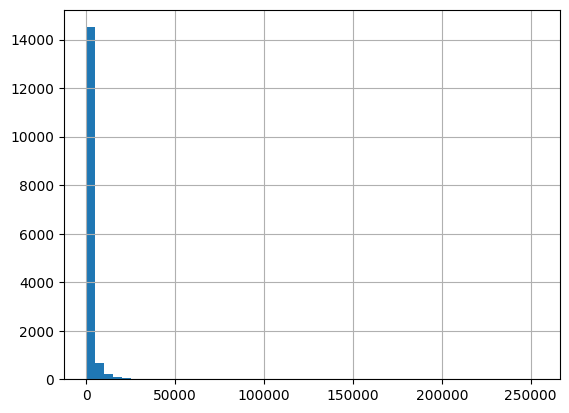

In [419]:
pd.Series(df['count']).hist(bins = 50)

In [420]:
len(df[df['count']<=2500])

13543

In [421]:
df[df['count']<50]['sec_text']

8        : \n  for  KKR  :  investment  firm  that  pr...
10       : \n–  for GIC: GIC is the holding company for...
11       : \n–  MAGNA is an automotive supplier which m...
13       (6)  Pursuant to an agreement and plan of merg...
18       : \n  Huaxin is a wholly PRC State-owned indu...
                               ...                        
15590    38.  For the above mentioned reasons, the Comm...
15598    (1258)  The Commission concludes that it is li...
15660    29.  For the above mentioned reasons, the Comm...
15665    26.  For the above mentioned reasons, the Comm...
15681    (25)  For the above mentioned reasons, the Com...
Name: sec_text, Length: 1478, dtype: object

#### Drop count with sec_text <=20

In [422]:
df = df[df['count']>20].reset_index(drop=True)

### III. Drop duplicates based on file and sec_text

In [423]:
df.drop_duplicates(subset=['file', 'sec_text'], keep='first', inplace=True)

df=df.reset_index(drop=True)

### IV. Rename Articles

In [424]:
df['article'] = df['article'].replace('art6.1', 'article6(2)')
df['article'] = df['article'].replace('art6.0', 'article6(1)(b)')
df['article'] = df['article'].replace('art8.1', 'article8(1)')
df['article'] = df['article'].replace('art8.2', 'article8(2)')
df['article'] = df['article'].replace('art8.3', 'article8(3)')
df['article'] = df['article'].replace('art9.3', 'referral')

In [427]:
# no. of cases by article_txt
df.groupby('article_txt')['case_num'].nunique().sort_index()

article_txt
None                83
article17(2)         8
article21            1
article22            4
article22(1)         1
article22(3)        13
article232           1
article4(4)         12
article6(1)          9
article6(1)(a)       1
article6(1)(b)    4657
article6(2)         55
article6(4)          1
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
article8(4)          1
article9             3
article9(2)          1
article9(3)         24
article9(3)(b)       2
Name: case_num, dtype: int64

In [428]:
# change 6(1) to 6.2
df['article_txt'] = df['article_txt'].replace("article6(1)", "article6(2)") 

In [429]:
df['article_62'].value_counts()

None                            13273
inconjunctionwithart6(2)         1225
inconjunctionwitharticle6(2)      120
Name: article_62, dtype: int64

In [430]:
# change to 6.2 with in conjunction
df['article_txt'] = np.where(df['article_62'].isin(['inconjunctionwitharticle6(2)', 'inconjunctionwithart6(2)']), 'article6(2)', df['article_txt'])

#### Clean article_new

In [440]:
# referral
mask = (df['article_txt'].isin(["article4(4)", "article22(3)", "article22", "article9(3)", "article9(3)(b)", "article9", "article9(2)"]))

In [441]:
# article_new
df['article_new'] = np.where(mask, 'referral', df['article_txt'])

In [442]:
# refusal - Article 7.3
mask73 = (df['article_txt'].isin(["article7(3)"]))
df['article_new'] = np.where(mask73, 'article7(3)', df['article_new'])

In [443]:
# no. of cases by article_new
df.groupby('article_new')['case_num'].nunique().sort_index()

article_new
None                83
article17(2)         8
article21            1
article22(1)         1
article232           1
article6(1)(a)       1
article6(1)(b)    4505
article6(2)        214
article6(4)          1
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
article8(4)          1
referral            59
Name: case_num, dtype: int64

### V. Subset based on articles

#### Subset only "article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral", "article7(3)"

In [444]:
# subset based on article_new (only main articles)
df1 = df[df['article_new'].isin(["article6(1)(b)", "article6(2)", "article8(1)", "article8(2)", "article8(3)", "referral", "article7(3)"])]

#### Replace Simplified Procedure

In [462]:
df1.loc[df1['len_pdf'] <= 5, 'article_new'] = 'simplified'

In [461]:
len(df1[df1['len_pdf']<=5]['sec_text'])

3220

In [463]:
# no of cases by article_new
df1.groupby('article_new')['case_num'].nunique()

article_new
article6(1)(b)    1285
article6(2)        214
article7(3)         28
article8(1)         33
article8(2)         63
article8(3)         10
referral            59
simplified        3220
Name: case_num, dtype: int64

In [464]:
# no of documents by article_new
df1.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    1287
article6(2)        218
article7(3)         29
article8(1)         33
article8(2)         64
article8(3)         10
referral            92
simplified        3220
Name: file, dtype: int64

### VI. Detect English sec_text and subset to English merger decisions

In [448]:
# Add language
from langdetect import detect

df1["lang"] = df1["sec_text"].apply(lambda x: detect(x) if x is not None else None)

C:\Users\admin\AppData\Local\Temp\ipykernel_18060\2238364212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["lang"] = df1["sec_text"].apply(lambda x: detect(x) if x is not None else None)


In [456]:
len(df1.index)

14107

In [455]:
df1['lang'].value_counts()

en    14097
fr        6
no        1
de        1
nl        1
id        1
Name: lang, dtype: int64

#### Drop non-English

In [522]:
df_eng = df1[df1['lang']=="en"]
df_eng = df_eng.reset_index(drop=True)

In [523]:
len(df_eng.index)

14097

In [524]:
df_eng.groupby('article_new')['file'].nunique()

article_new
article6(1)(b)    1287
article6(2)        218
article7(3)         29
article8(1)         33
article8(2)         64
article8(3)         10
referral            92
simplified        3213
Name: file, dtype: int64

### VII. Clean Section headings

#### Save headings to excel file

In [833]:
headings = df_eng['section'].value_counts()

In [834]:
df_eng['section2'] = df_eng['section'].str.findall(r'\b[A-Z\s]+\b').str.join(' ').str.strip()

In [835]:
headings2 = pd.DataFrame(df_eng['section2'].value_counts()).reset_index()
headings2.columns = ['section', 'count']
headings2 = headings2.explode('section')

In [836]:
headings2.to_excel('D:\Desktop\Thesis\predicting-merger-decision-outcomes\output\headings.xlsx')

In [837]:
headings2.head(10)

,section,count
0,CONCLUSION,730
1,COMPETITIVE ASSESSMENT,557
2,I THE PARTIES,547
3,THE PARTIES,497
4,EU DIMENSION,436
5,VI CONCLUSION,380
6,V COMPETITIVE ASSESSMENT,321
7,II THE OPERATION,275
8,RELEVANT MARKETS,251
9,III COMMUNITY DIMENSION,251


#### Rename Sections into 7 general subheadings

In [1342]:
df_eng['section_fin'] = ""

DROP subheadings

In [1343]:
df_eng['section_fin'] = np.where((df_eng['section2']==""), 'DROP', df_eng['section_fin'])

In [1344]:
len(df_eng[df_eng['section_fin']=="DROP"])

15

1. Introduction, Background, Summary

In [1345]:
mask_intro = df_eng['section2'].str.lower().str.contains('introduction|summary|background')

In [1346]:
df_eng['section_fin'] = np.where(mask_intro, 'Introduction/ Summary', "")

2. Parties, Operation, Transaction

In [1347]:
mask_party = df_eng['section2'].str.lower().str.contains('parties|operation|transaction|joint venture')

In [1348]:
df_eng['section_fin'] = np.where(mask_party, 'Parties & Operation', df_eng['section_fin'])

3. Concentration & Dimension

In [1349]:
mask_dim = df_eng['section2'].str.lower().str.contains('concentration|dimension|community dimmension|jurisdiction of the commission')

In [1350]:
df_eng['section_fin'] = np.where(mask_dim, 'Concentration & Dimension', df_eng['section_fin'])

4. Market Definition

In [1351]:
mask_market = df_eng['section2'].str.lower().str.contains('relevant market|product|geographic|industry|market definition|marketdefinition|marketdefinitions|market|definition|definitions|united kingdom|germany|slovakia|hungary|czechia|applicability of the eea agreement|wholesale|retail|telecommunications sector|upstream|downstream|cargo transport and freight forwarding|cementitious materials|fluid catalytic cracking fcc trains|adgt  driven|adgt|steam turbines|greycement|high and very high speed')

In [1352]:
df_eng['section_fin'] = np.where(mask_market, 'Relevant Markets', df_eng['section_fin'])

5. Competitive Assessment

In [1353]:
mask_assess = df_eng['section2'].str.lower().str.contains('competitive assessment|analysis|analyses|assessment|investigation|effect|horizontal|vertical|conglomerate|coordinated|foreclosure|nash|bertrand|data|robustness tests|methodology|method|efficiencies|competitive assesment|competitiveassesment|competitiveasessment|competitive asessment|share|competitive  structure|merger simulation|simulation|recent studies|overview of the commission s approach|cashinstruments')

In [1354]:
df_eng['section_fin'] = np.where(mask_assess, 'Competitive Assessment', df_eng['section_fin'])

6. Conclusion

In [1355]:
mask_conclusion = df_eng['section2'].str.lower().str.contains('conclusion')

In [1356]:
df_eng['section_fin'] = np.where(mask_conclusion, 'Conclusion', df_eng['section_fin'])

7. Conditions

In [1357]:
mask_commit = df_eng['section2'].str.lower().str.contains('commitment|remedies|remedy|obligation|condition|general provisions|slots|fare combinability')

In [1358]:
df_eng['section_fin'] = np.where(mask_commit, 'Conditions', df_eng['section_fin'])

8. Decision

In [1359]:
mask_decision = df_eng['section2'].str.lower().str.contains('facts|fact|procedure|procedures|decision')

In [1360]:
df_eng['section_fin'] = np.where(mask_decision, 'Decision', df_eng['section_fin'])

9. Requests

In [1361]:
mask_req = df_eng['section2'].str.lower().str.contains('request|requests|referral|review clause')

In [1362]:
df_eng['section_fin'] = np.where(mask_req, 'Request', df_eng['section_fin'])

10. Monitoring Trustee

In [1363]:
mask_monitor = df_eng['section2'].str.lower().str.contains('monitor|monitoring|termination mandate|relationship with state aid rules')

In [1364]:
df_eng['section_fin'] = np.where(mask_monitor, 'Monitoring', df_eng['section_fin'])

11. None for Simplified Procedure

In [1365]:
df_eng.loc[df_eng['len_pdf'] <= 5, 'section_fin'] = 'simplified'

12. For remaining Art 6.2 and 8.2 - Conditions

In [1366]:
df_eng.loc[(df_eng['article_new'].isin(["article6(2)", "article8(2)"]) & (df_eng['section_fin']=="")), 'section_fin'] = 'Conditions'

13. For remaining Art 6.1(b) and 8.3 - Competitive Assessment

In [1367]:
df_eng.loc[((df_eng['article_new'].isin(["article6(1)(b)","article8(3)"])) & (df_eng['section_fin']=="")), 'section_fin'] = 'Competitive Assessment'

Others - 7.3 and Referral

In [1368]:
df_eng.loc[((df_eng['article_new'].isin(["referral","article7(3)"])) & (df_eng['section_fin']=="")), 'section_fin'] = 'Others'

DROP subheadings

In [1369]:
df_eng.loc[((df_eng['section_fin']=="") & (df_eng['section2']=="")), 'section_fin'] = 'DROP'

In [1370]:
mask_drop = df_eng['section2'].str.lower().str.contains('comp m|cash instruments|derivatives')
df_eng['section_fin'] = np.where(mask_drop, 'DROP', df_eng['section_fin'])

In [1371]:
df_eng['section_fin'].value_counts()

simplified                   3213
Concentration & Dimension    2609
Parties & Operation          2183
Competitive Assessment       1934
Conclusion                   1686
Relevant Markets             1069
Conditions                    835
Introduction/ Summary         170
DROP                          117
Request                       113
Decision                      106
Others                         39
Monitoring                     23
Name: section_fin, dtype: int64

In [1373]:
# # save json file name
# date = datetime.date.today().strftime('%Y_%m_%d')

# file_name = f"../../../data/processed/df_eng_cleaned_{date}.json"
# if os.path.exists(file_name):
#     os.remove(file_name)

# # save file as json
# df_eng.to_json(file_name)

In [1132]:
# df_eng[df_eng['section_fin']==""]['section2'].nunique()

In [1133]:
# df_eng[(df_eng['section_fin']=="")].groupby('article_new')['case_num'].nunique()

In [864]:
# headings3 = pd.DataFrame(df_eng[(df_eng['section_fin']=="") & (df_eng['article_new']!="referral") & (df_eng['article_new']!="article7(3)")]['section2'].value_counts()).reset_index()
# headings3.columns = ['section', 'count']
# headings3 = headings3.explode('section')

In [866]:
# headings3.to_excel('D:\Desktop\Thesis\predicting-merger-decision-outcomes\output\headings_filtered.xlsx')

In [1130]:
# df_eng[df_eng['section2']==""][['sec_text','article_new']]

In [1131]:
# print(df_eng['sec_text'][13921])

### VIII. Filter based on 'section'/subheading and article_new

In [1374]:
df_eng['section_fin'].value_counts()

simplified                   3213
Concentration & Dimension    2609
Parties & Operation          2183
Competitive Assessment       1934
Conclusion                   1686
Relevant Markets             1069
Conditions                    835
Introduction/ Summary         170
DROP                          117
Request                       113
Decision                      106
Others                         39
Monitoring                     23
Name: section_fin, dtype: int64

In [1375]:
df_eng_filtered = df_eng[(~df_eng['article_new'].isin(["article7(3)"]) & 
                          ~df_eng['section_fin'].isin(["DROP", "Conclusion", "Decision",
                                                       "Conditions", "Request", "Monitoring",
                                                       "Introduction/ Summary", "Others"]))]

In [1376]:
df_eng_filtered['section_fin'].value_counts()

simplified                   3213
Concentration & Dimension    2587
Parties & Operation          2156
Competitive Assessment       1934
Relevant Markets             1069
Name: section_fin, dtype: int64

In [1377]:
df_eng_filtered['article_new'].value_counts()

article6(1)(b)    5913
simplified        3213
article6(2)        968
article8(2)        384
referral           256
article8(1)        162
article8(3)         63
Name: article_new, dtype: int64

In [1378]:
# no. of cases by article_new
df_eng_filtered.groupby('article_new')['case_num'].nunique().sort_index()

article_new
article6(1)(b)    1284
article6(2)        203
article8(1)         30
article8(2)         59
article8(3)          9
referral            59
simplified        3213
Name: case_num, dtype: int64

In [1379]:
# no. of files by article_new
df_eng_filtered.groupby('article_new')['file'].nunique().sort_index()

article_new
article6(1)(b)    1286
article6(2)        205
article8(1)         30
article8(2)         60
article8(3)          9
referral            92
simplified        3213
Name: file, dtype: int64

#### Drop unnecessary columns

In [1382]:
df_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14097 entries, 0 to 14096
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          14097 non-null  object 
 1   year          14046 non-null  float64
 2   len_pdf       14097 non-null  int64  
 3   article       14097 non-null  object 
 4   article_txt   14097 non-null  object 
 5   article_62    14097 non-null  object 
 6   article_new   14097 non-null  object 
 7   case_num      14097 non-null  object 
 8   filename      14097 non-null  object 
 9   file          14097 non-null  object 
 10  section_text  14097 non-null  object 
 11  bsn_act       14097 non-null  object 
 12  simp_text     14097 non-null  object 
 13  section       10884 non-null  object 
 14  sec_text      14097 non-null  object 
 15  count         14097 non-null  int64  
 16  lang          14097 non-null  object 
 17  section2      10884 non-null  object 
 18  section_fin   14097 non-nu

In [1383]:
df_eng_filtered = df_eng_filtered.drop(columns=['date', 'article', 'article_txt', 'article_62', 'filename',
                                                'section_text', 'bsn_act', 'simp_text','section','section2'])

In [1384]:
# save json file name
date = datetime.date.today().strftime('%Y_%m_%d')

file_name = f"../../../data/processed/df_eng_clean_filtered_{date}.json"
if os.path.exists(file_name):
    os.remove(file_name)

# save file as json
df_eng_filtered.to_json(file_name)